In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(31, 24)

In [6]:
df_states.shape

(1597, 25)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-03-30,56,160530,784324,65369,12147.0,22303.0,2982.0,3177.0,259.0,...,2939,22303.0,1010223,944854,944854,511.0,2902.0,92034.0,21469.0,113503.0
3,2020-03-31,56,184683,864201,59518,14236.0,26660.0,3402.0,3644.0,69.0,...,3746,26660.0,1108402,1048884,1048884,807.0,4357.0,79877.0,24153.0,104030.0
2,2020-04-01,56,210770,939190,59669,16223.0,31142.0,3837.0,4270.0,71.0,...,4700,31142.0,1209629,1149960,1149960,954.0,4482.0,74989.0,26087.0,101076.0
1,2020-04-02,56,239009,1028649,62101,17157.0,32649.0,4264.0,541.0,67.0,...,5784,32649.0,1329759,1267658,1267658,1084.0,1507.0,89459.0,28239.0,117698.0
0,2020-04-03,56,271915,1135356,61980,19926.0,35991.0,4686.0,593.0,70.0,...,6962,35991.0,1469251,1407271,1407271,1178.0,3342.0,106707.0,32906.0,139613.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-03,NE,279.0,4487.0,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,4777,4766,4766,31,1.0,0.0,509.0,33.0,542.0
31,2020-04-03,ND,173.0,5625.0,NaN,NaN,29.0,NaN,NaN,NaN,...,29.0,5798,5798,5798,38,0.0,1.0,804.0,14.0,818.0
30,2020-04-03,NC,2093.0,29505.0,NaN,184.0,259.0,NaN,NaN,NaN,...,259.0,31598,31598,31598,37,3.0,55.0,2683.0,236.0,2919.0
28,2020-04-03,MS,1358.0,4753.0,NaN,NaN,420.0,NaN,NaN,NaN,...,420.0,6111,6111,6111,28,3.0,60.0,0.0,181.0,181.0
0,2020-04-03,AK,157.0,5859.0,NaN,NaN,15.0,NaN,NaN,NaN,...,15.0,6016,6016,6016,2,0.0,6.0,980.0,14.0,994.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per million
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e6)

# Calculate hospitalized per million
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e6)

# Calculate deaths per million
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e6)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per million people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e6)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [13]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
1516,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1517,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
1518,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1519,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1520,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [14]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,1521.000000,1416.000000,440.000000,102.000000,415.000000,31.000000,57.000000,28.000000,40.000000,119.000000,...,1469.000000,1521.000000,1.521000e+03,1502.000000,1521.000000,415.000000,864.000000,1411.000000,1416.000000,556.000000
mean,1167.080210,6142.714689,1516.027273,1092.205882,545.349398,867.483871,360.929825,25.928571,119.875000,386.840336,...,956.666440,29.525312,6.532056e+06,429.445397,133.496607,51.908795,4.754871,0.125688,1291.691491,34.373073
std,5903.060222,13952.248538,8849.576656,2913.480931,2257.837793,1136.951505,709.151653,35.207247,164.150679,1370.387338,...,2314.471811,16.312396,7.363074e+06,1600.949197,368.623475,119.955866,11.391588,0.141889,1930.163562,117.297465
min,0.000000,0.000000,-3.000000,2.000000,0.000000,9.000000,6.000000,4.000000,4.000000,2.000000,...,-585.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,113.000000,4.000000,32.500000,22.500000,14.000000,14.000000,6.000000,11.250000,21.000000,...,16.000000,16.000000,1.805832e+06,54.955978,2.241476,10.392850,0.329555,0.044911,34.021364,2.428571
50%,83.000000,1106.000000,21.500000,63.500000,83.000000,410.000000,51.000000,19.000000,38.000000,37.000000,...,130.000000,29.000000,4.468402e+06,108.860290,24.674916,24.328066,1.341300,0.083333,355.243451,7.857143
75%,479.000000,5590.500000,114.250000,295.500000,261.000000,1436.500000,222.000000,32.500000,170.500000,76.000000,...,833.000000,42.000000,7.535591e+06,229.511156,127.509501,45.402260,4.091930,0.153176,1865.957795,22.428571
max,102863.000000,168139.000000,64400.000000,14810.000000,23696.000000,3731.000000,3022.000000,193.000000,535.000000,8886.000000,...,32037.000000,72.000000,3.955704e+07,11490.119540,5263.632172,1212.554835,150.187730,0.891705,13867.521323,1672.857143


## California

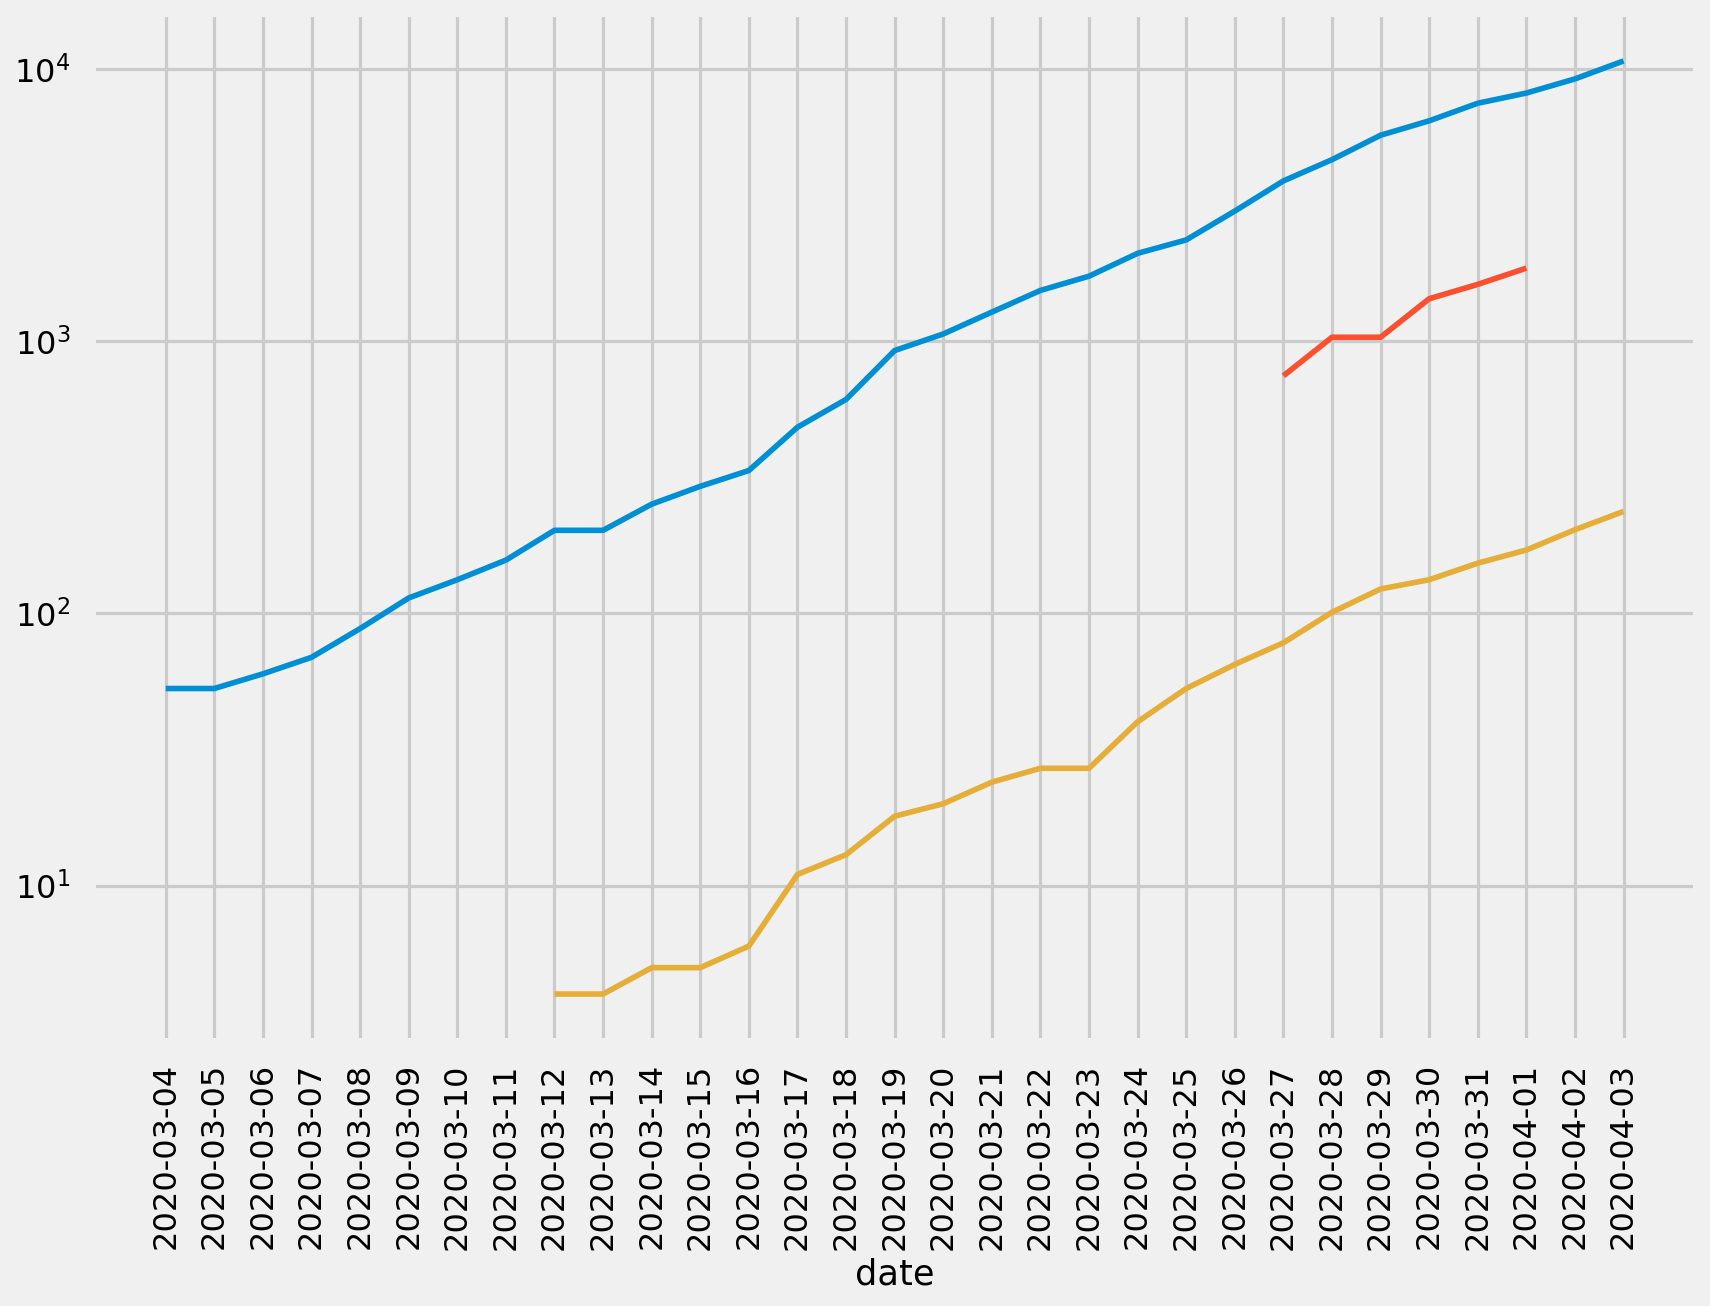

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

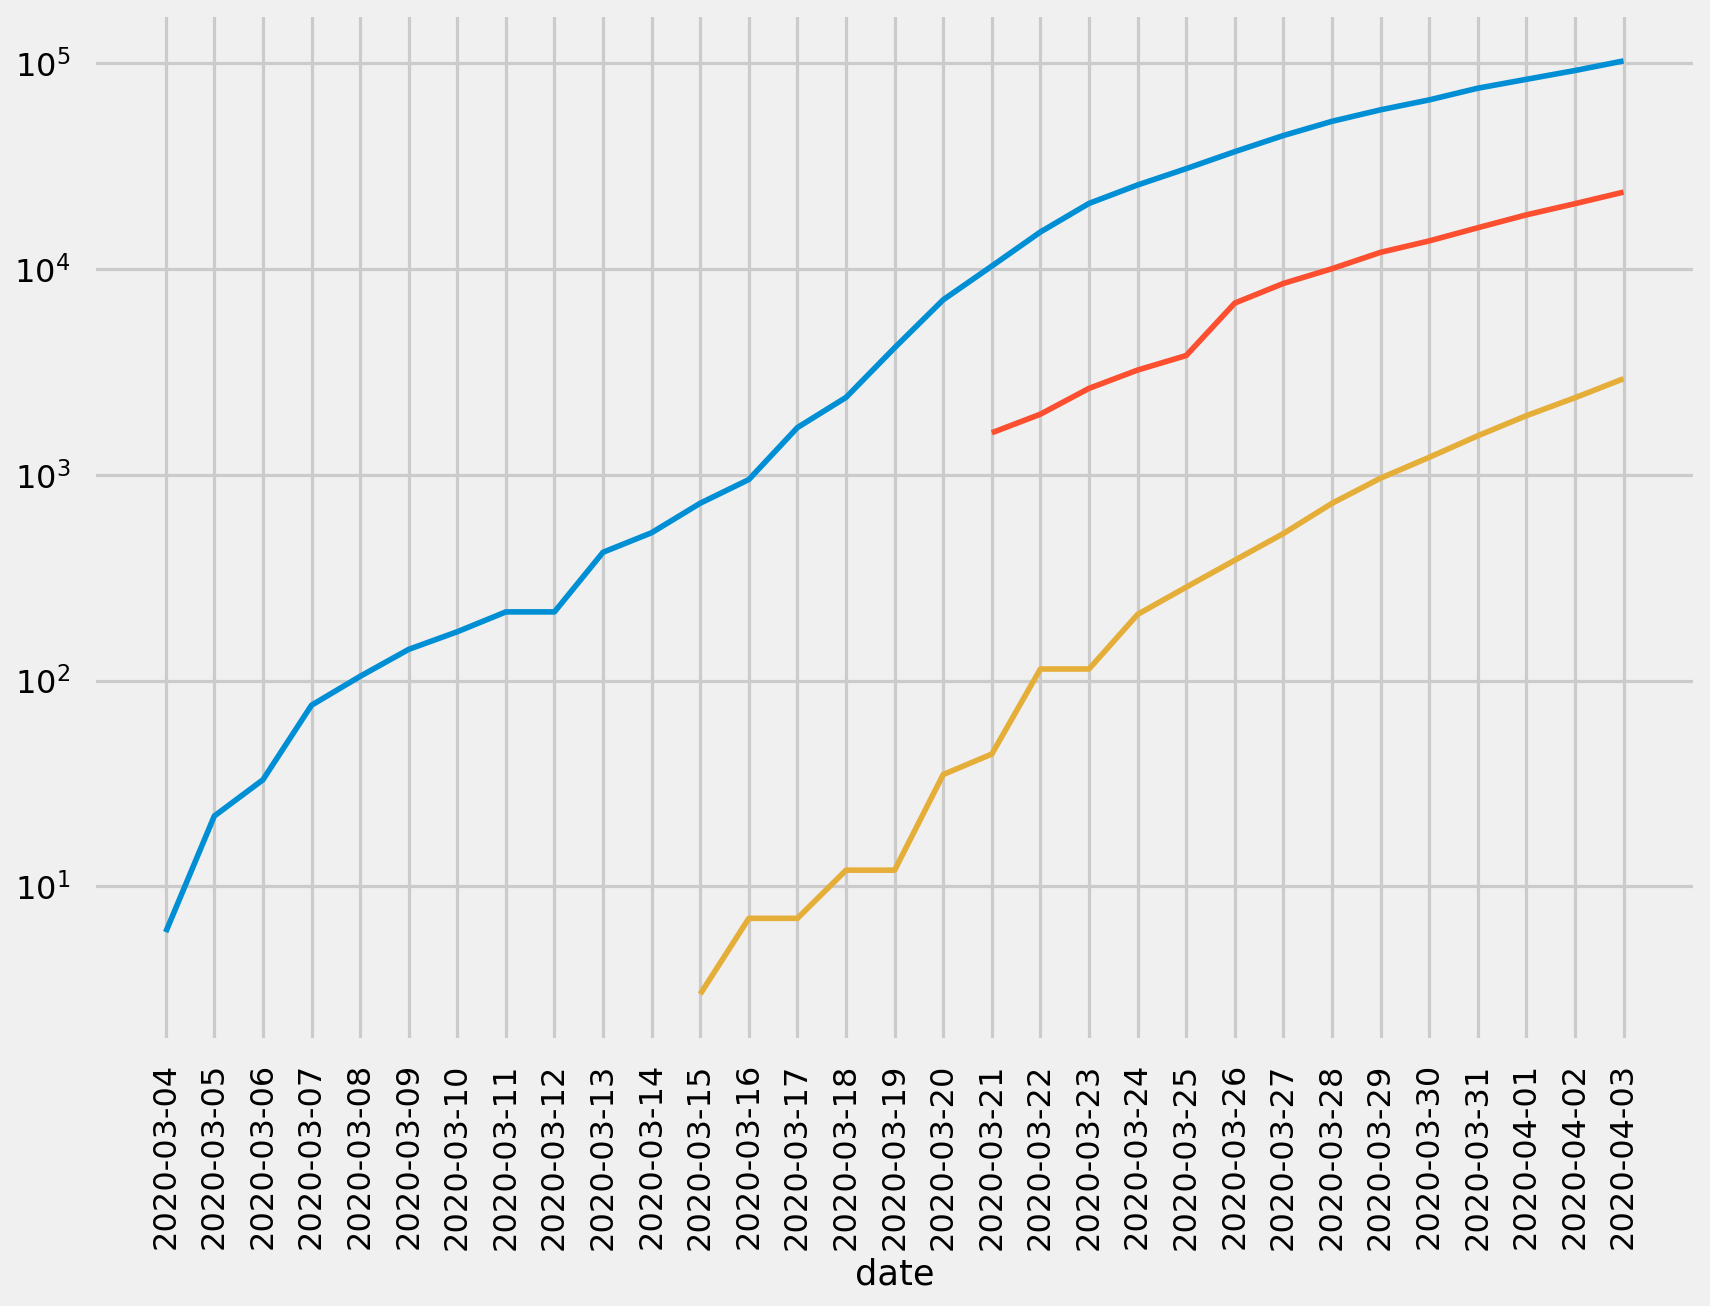

In [16]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [17]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'LA', 'WA', 'CA', 'IL', 'MA', 'GA', 'FL']

In [18]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
999,NY,2935.0
910,NJ,646.0
647,MI,479.0
530,LA,370.0
1402,WA,262.0
117,CA,237.0
412,IL,210.0
558,MA,192.0
296,GA,184.0
265,FL,163.0


In [19]:
# Deaths per million people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
999,NY,150.187730
530,LA,79.399516
910,NJ,72.514851
647,MI,47.919575
178,CT,36.667306
1402,WA,34.768341
558,MA,27.817423
1373,VT,27.143585
206,DC,21.353681
296,GA,17.491367


# Deaths

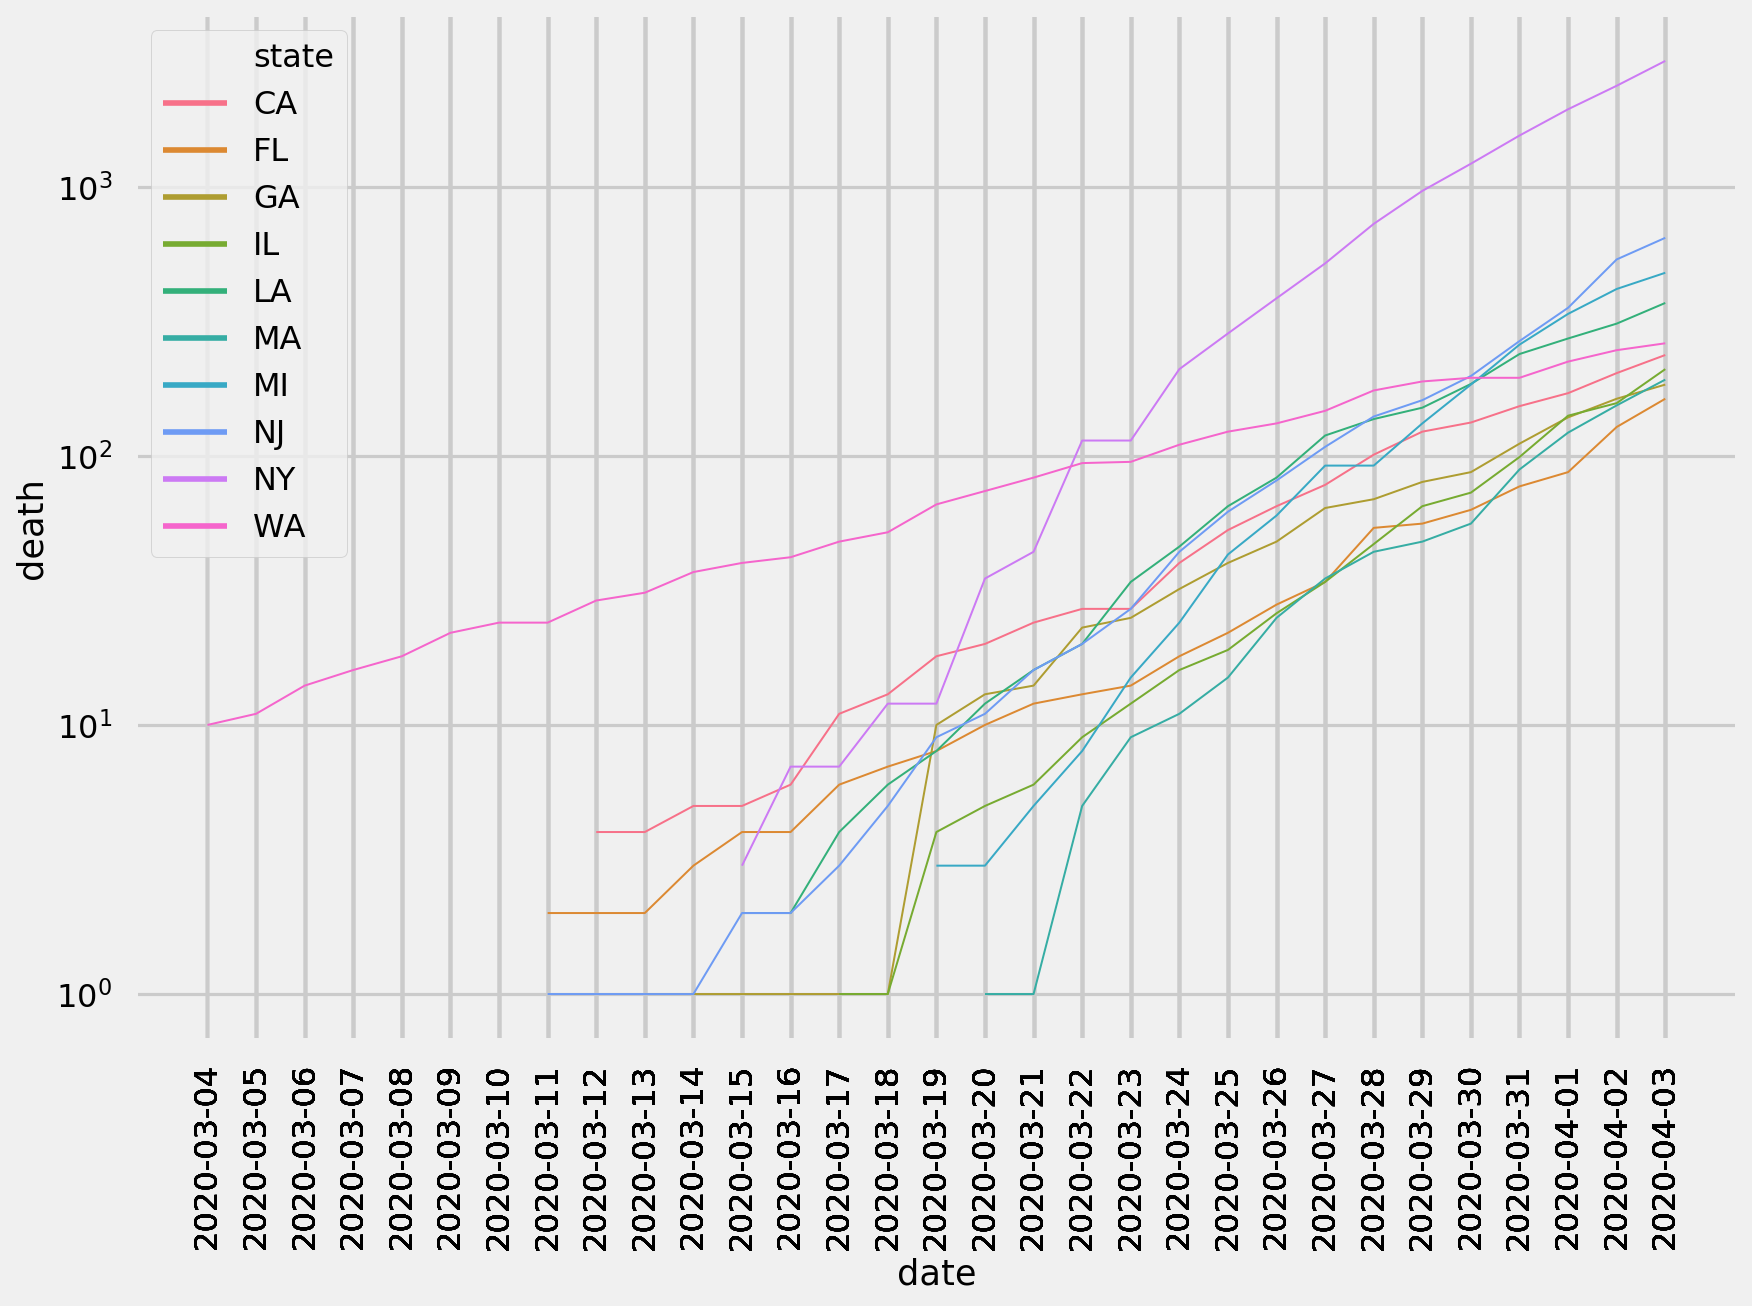

In [20]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

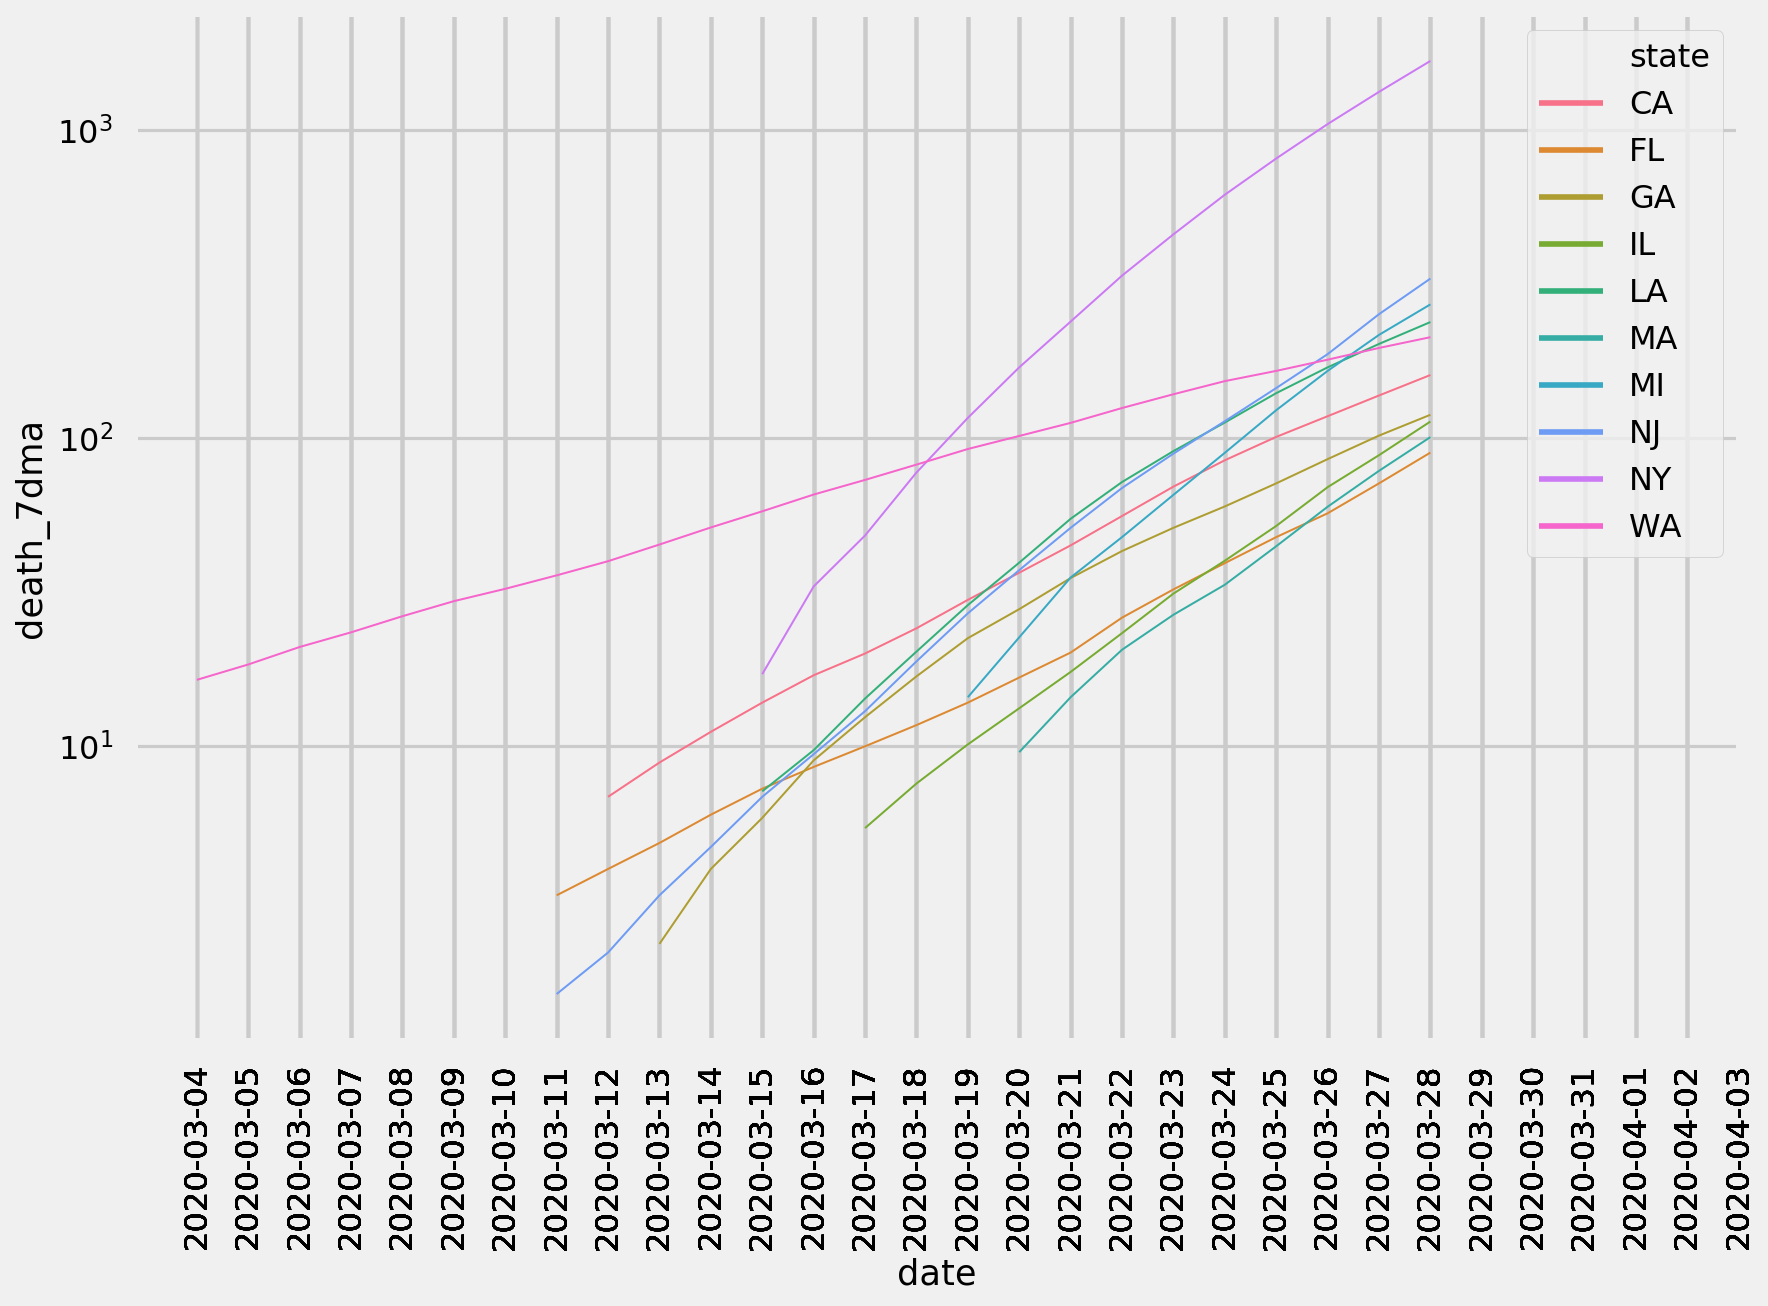

In [21]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per Million People

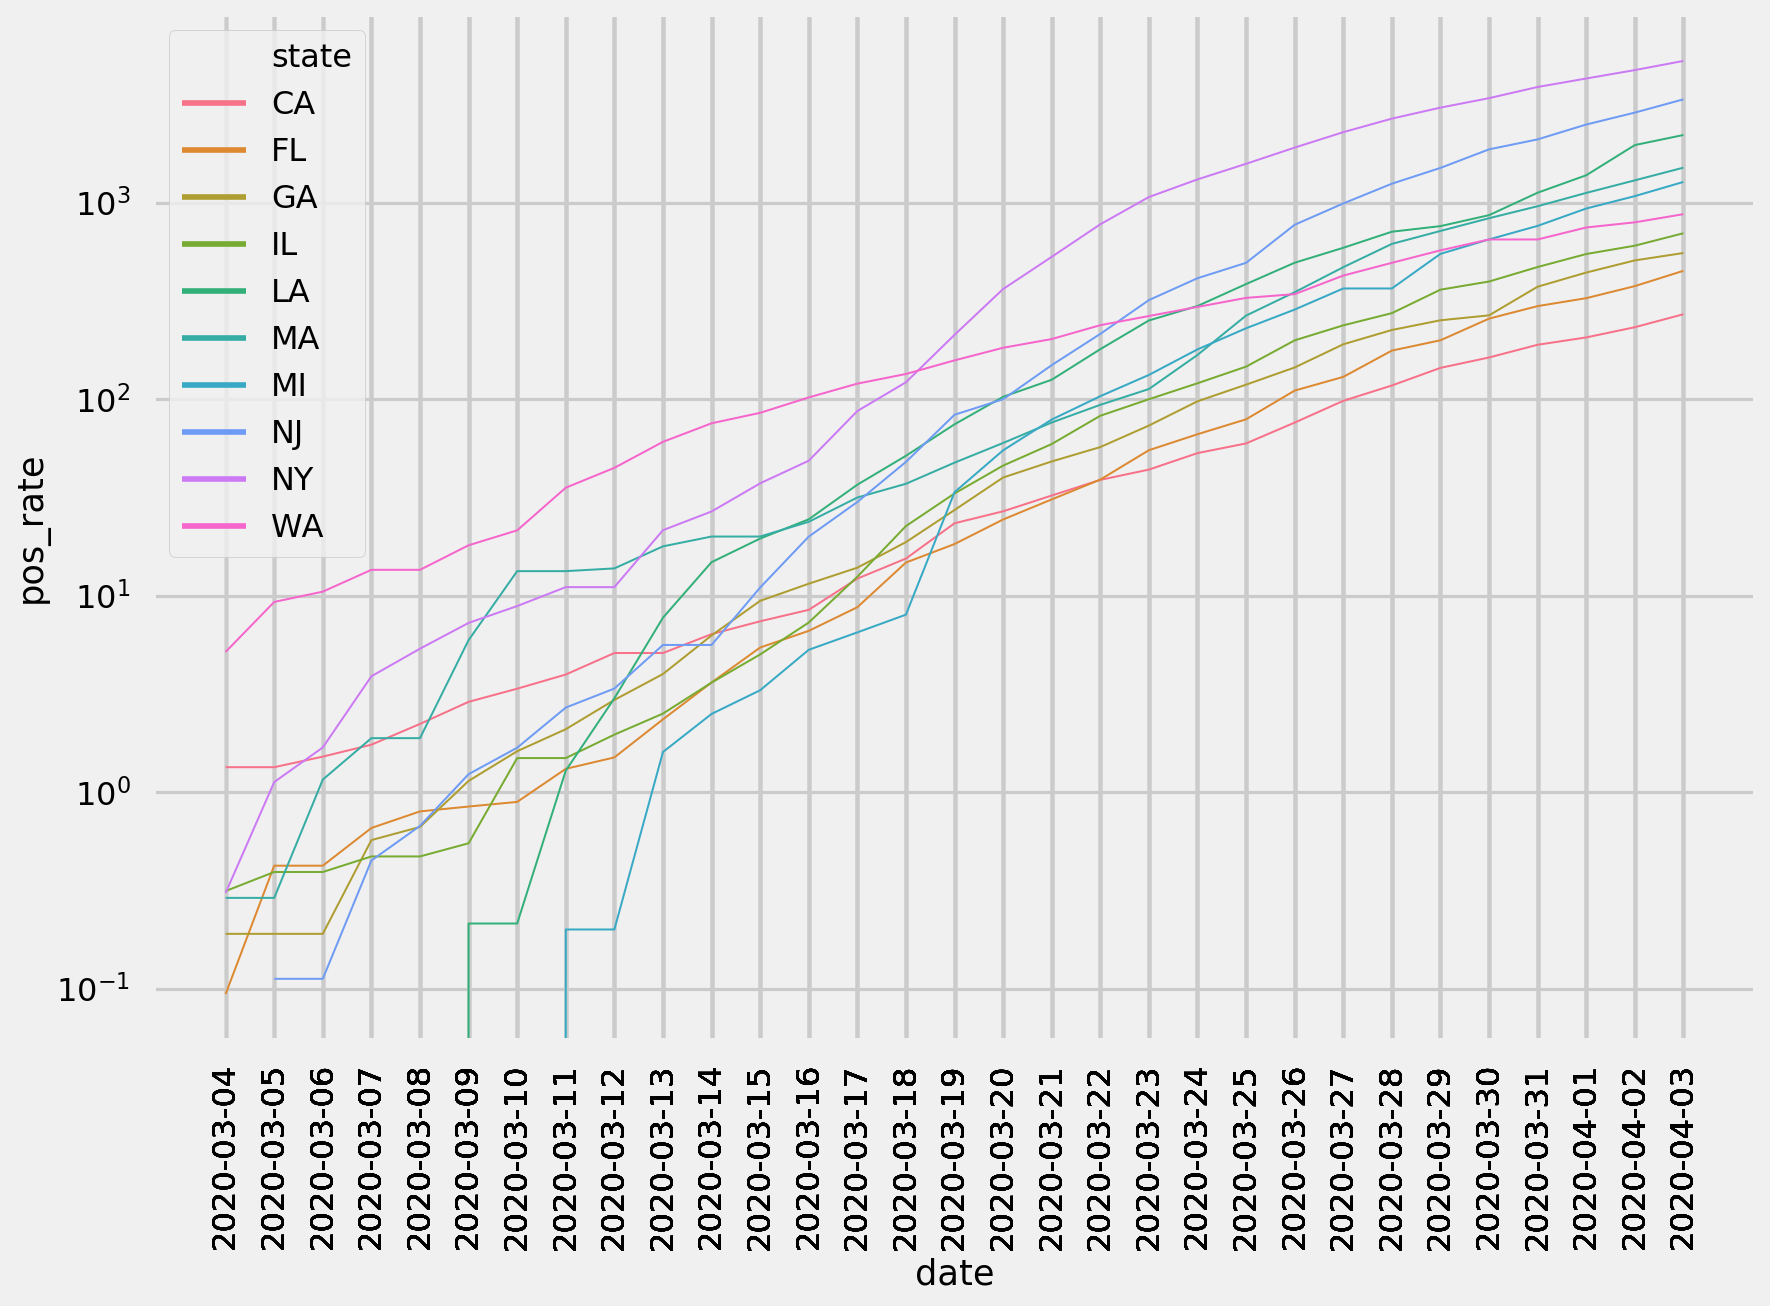

In [22]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Hospitalized Per Million People

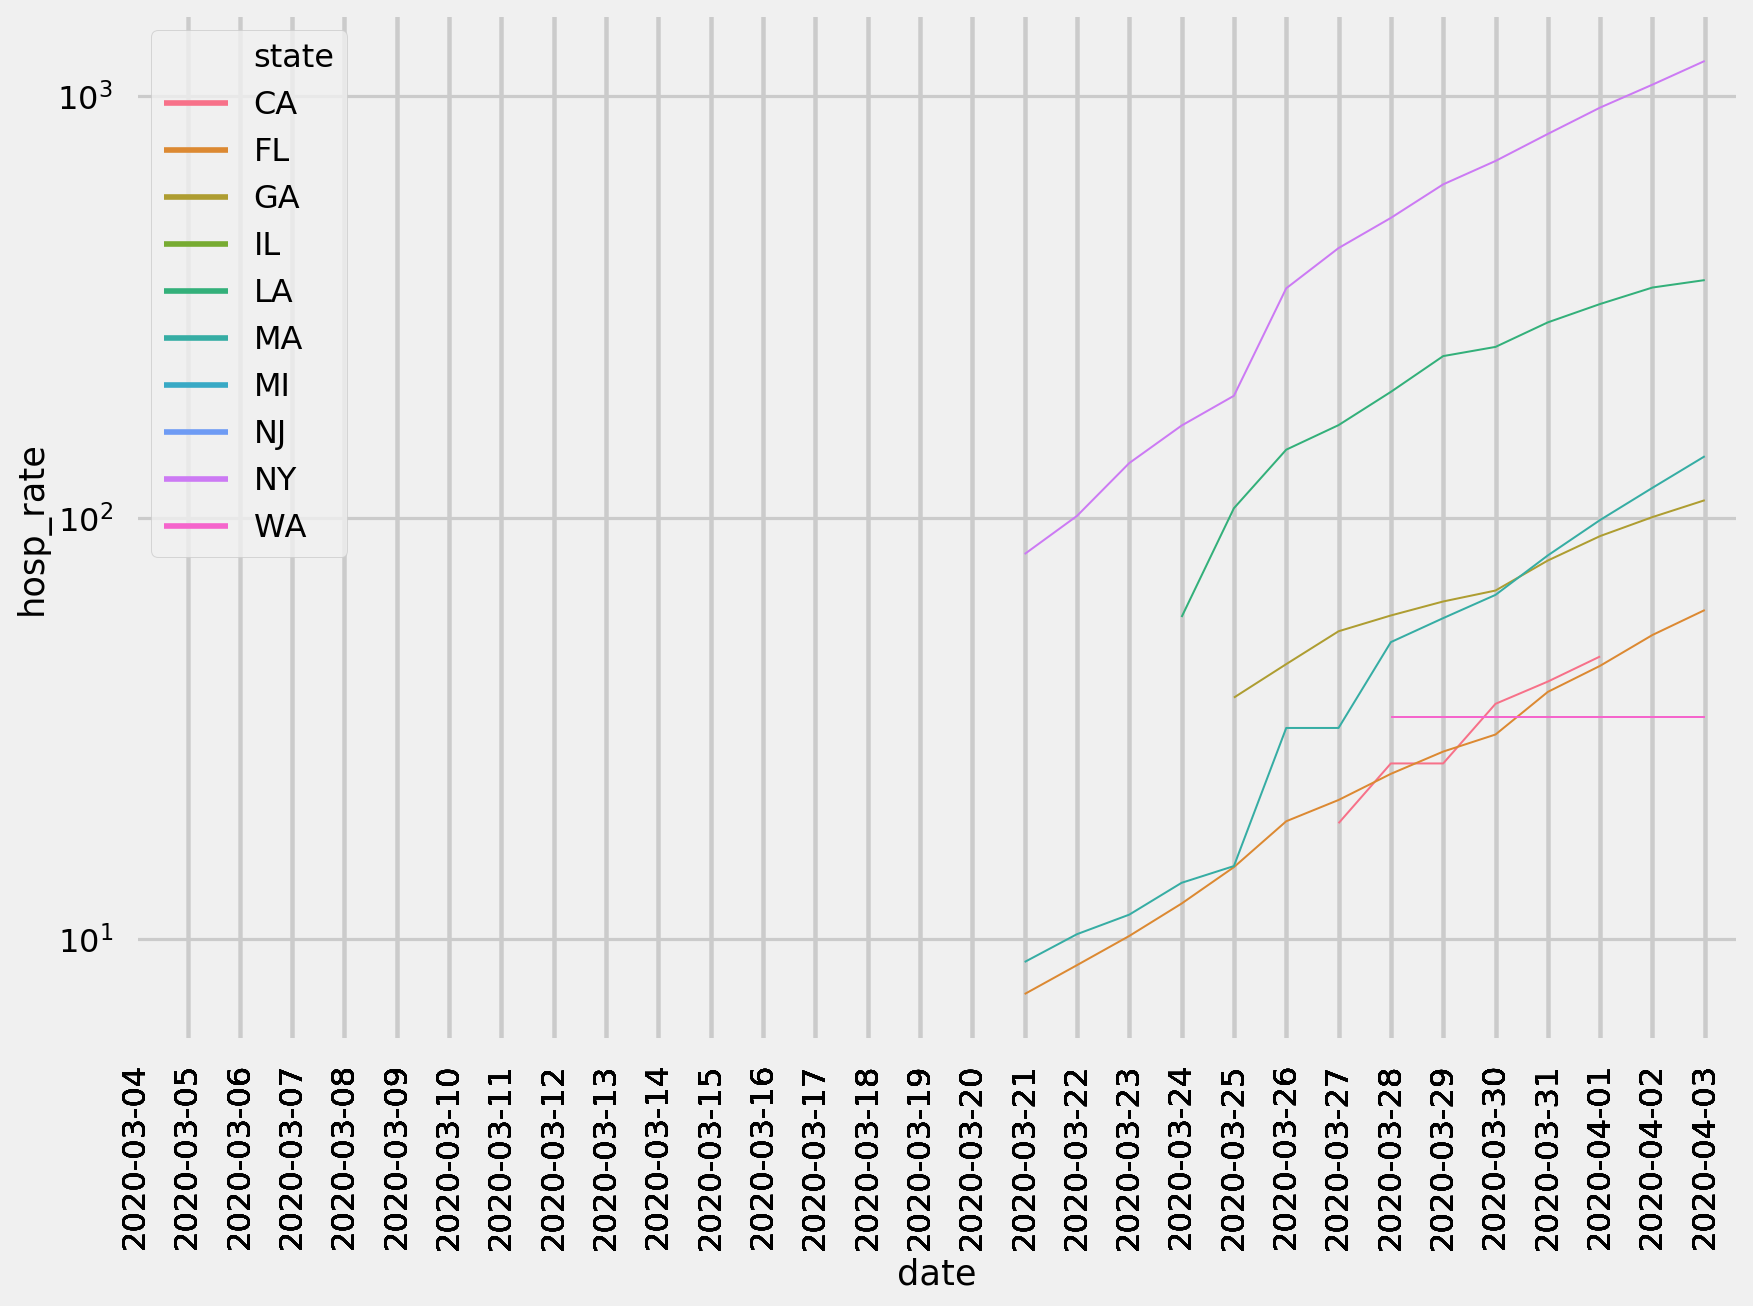

In [23]:
ax = sns.lineplot(x="date", y="hosp_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per Million People

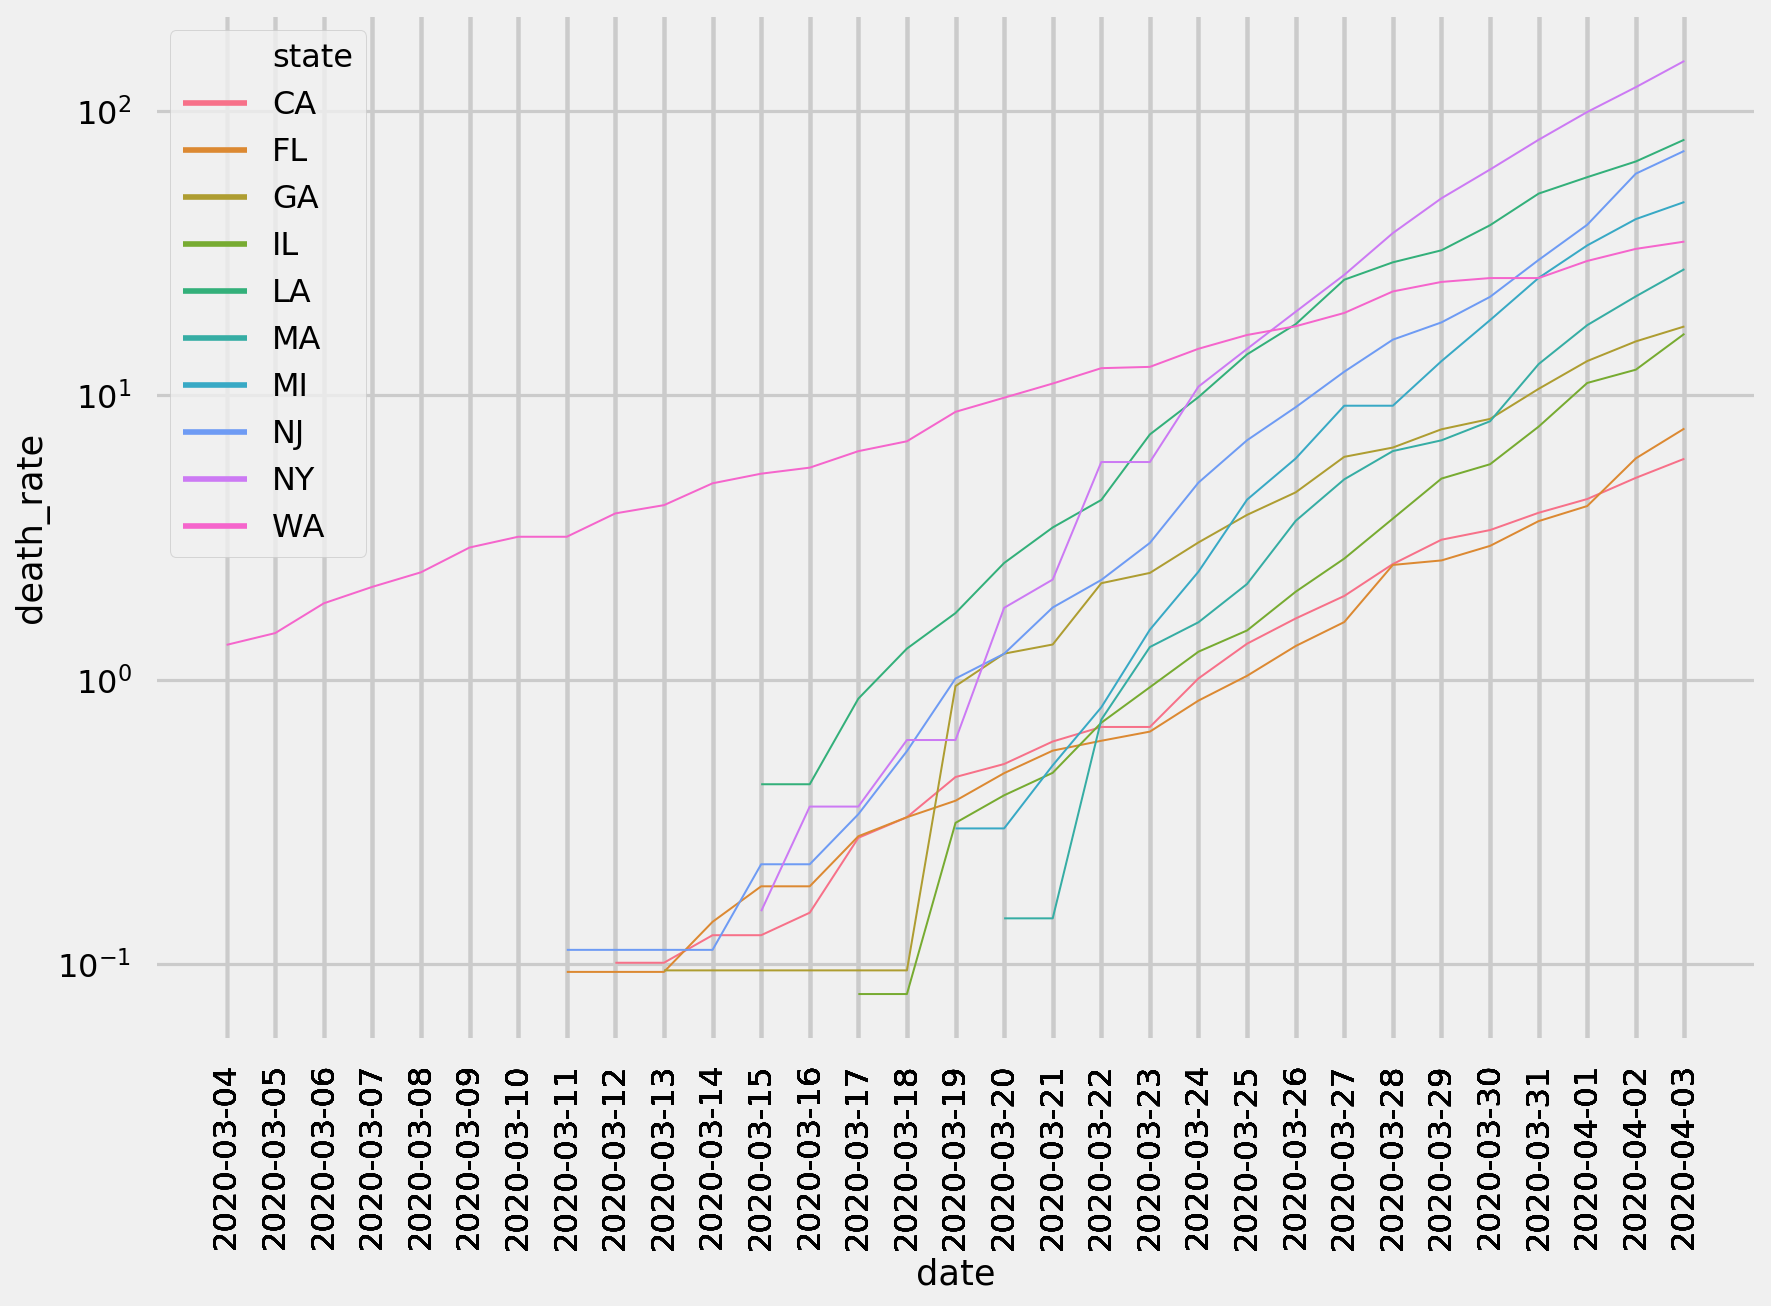

In [24]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per Million People

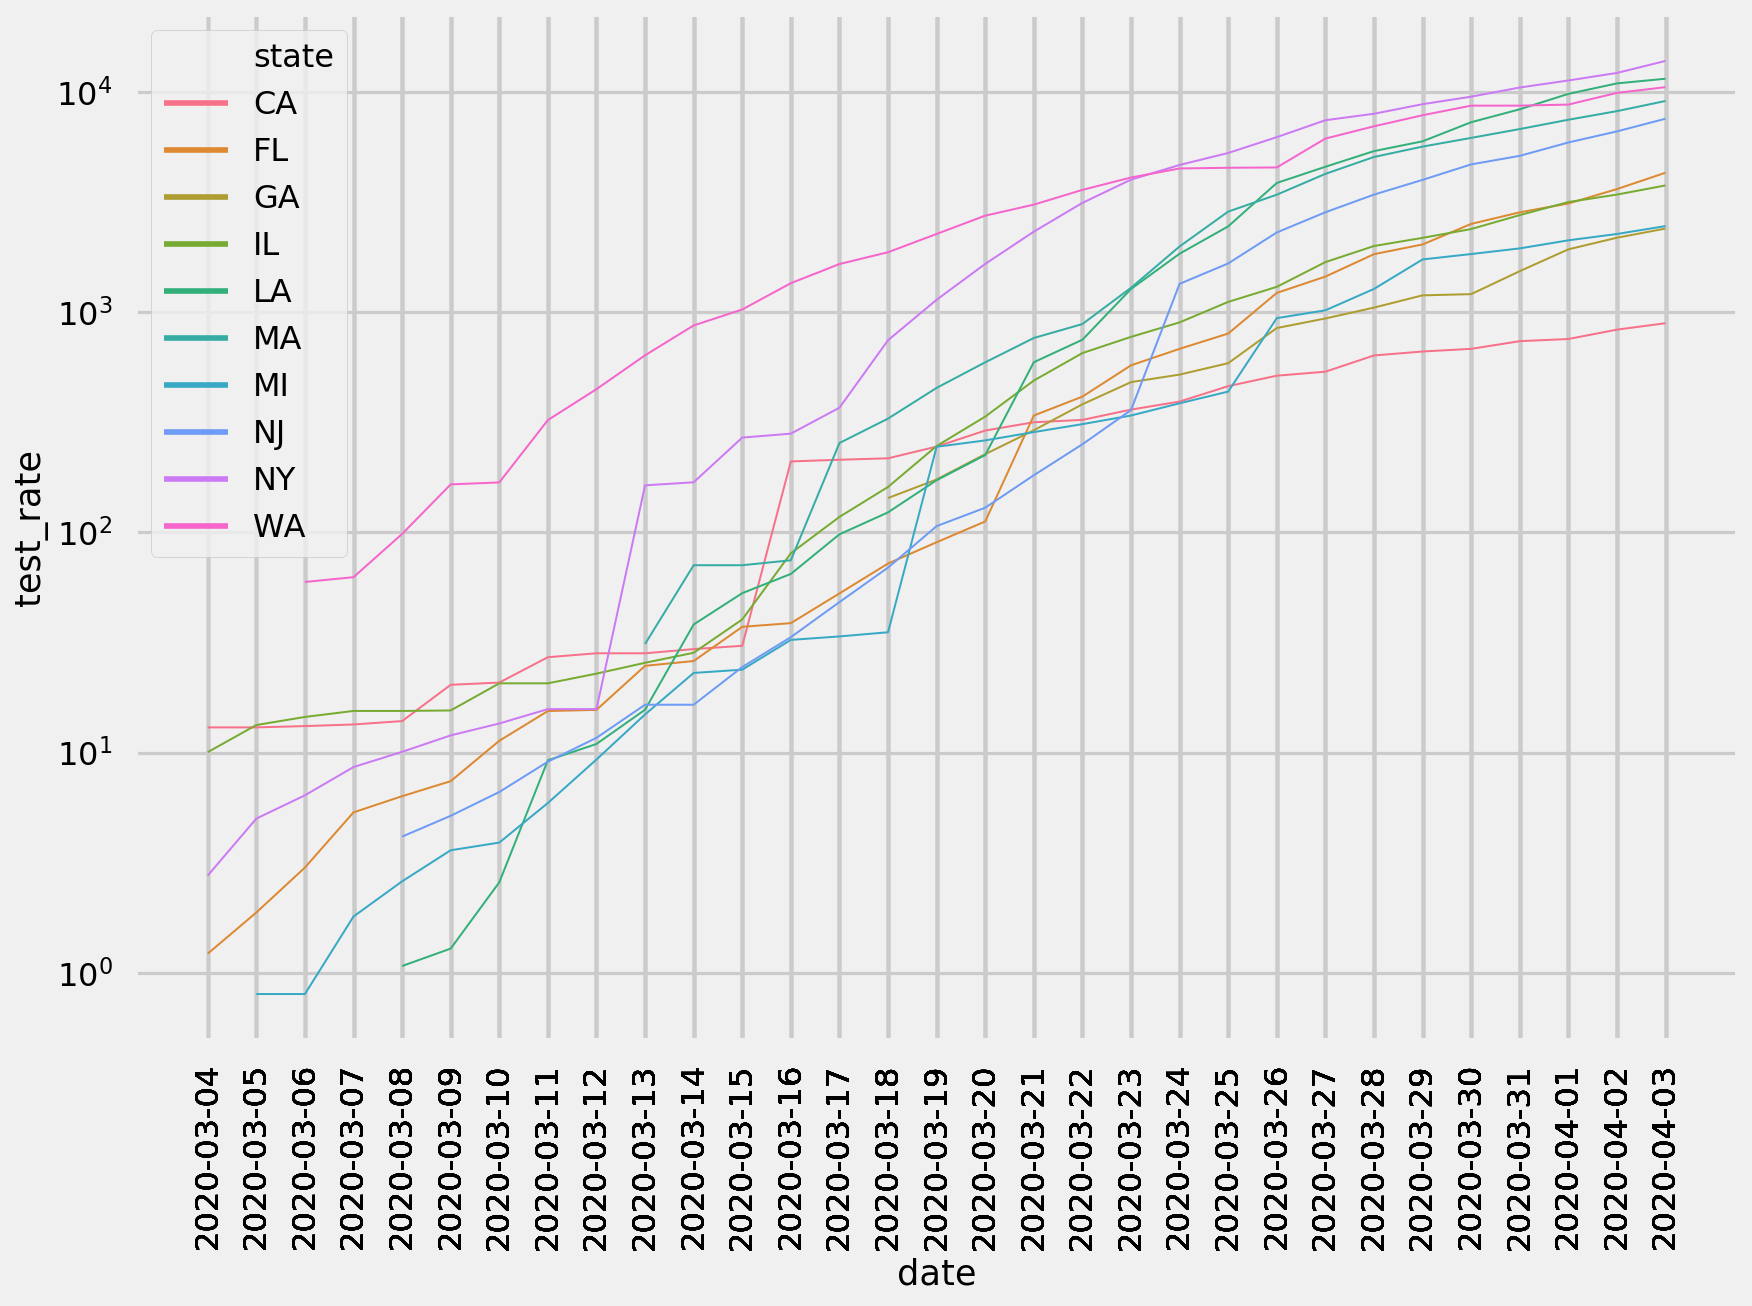

In [25]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [26]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
999,NY,13867.521323
530,LA,11511.856923
1402,WA,10539.053938
558,MA,9122.086469
1373,VT,8347.450659
0,AK,8157.973958
206,DC,7949.263654
1315,UT,7670.735392
821,ND,7628.174514
910,NJ,7577.352916
